In [1]:
from dataclasses import dataclass
from enum import StrEnum
from datetime import datetime, timedelta
import polars as pl
from collections import defaultdict, Counter
from typing import Tuple
from common.constants.column_types import (
    CPZP_SCHEMA,
    OZP_SCHEMA,
    POHLAVI_CPZP,
    TYP_UDALOSTI,
)
from common.constants.column_names import SHARED_COLUMNS, OZP_COLUMNS, CPZP_COLUMNS
import pickle
from common.constants.objects import (
    Person,
    Gender,
    AgeCohort,
    Prescription,
    PrescriptionType,
)
from common.utils import draw_chart, draw_bar_chart
import matplotlib.pyplot as plt
import numpy as np
import os

pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(60)

polars.config.Config

In [30]:
POJISTOVNA = "cpzp"
with open(f"./DATACON_data/{POJISTOVNA}_persons.pkl", "rb") as f:
    persons: list[Person] = pickle.load(f)

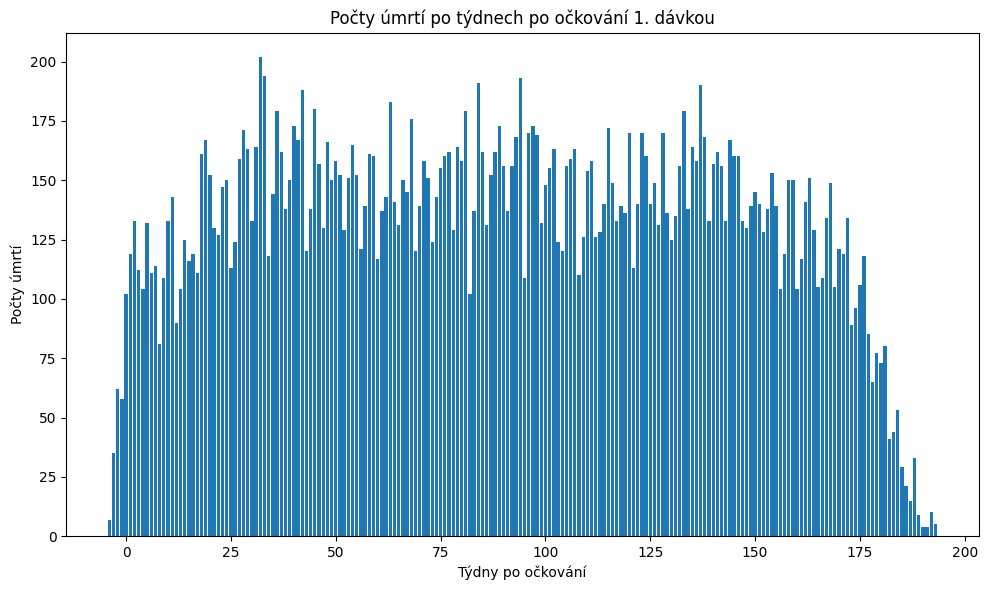

In [31]:
tydny_po_ockovani_map = defaultdict(int)
for person in persons:
    if not person.died_at:
        continue
    for vaccine in person.vaccines:
        if vaccine.dose_number != 1:
            continue
        relative_date = person.died_at - vaccine.date
        tydny_po_ockovani_map[relative_date.days // 7] += 1

data = dict(sorted(tydny_po_ockovani_map.items()))

x = list(data.keys())
y = list(data.values())

plt.figure(figsize=(10, 6))
plt.bar(x, y)

plt.xlabel("Týdny po očkování")
plt.ylabel("Počty úmrtí")
plt.title("Počty úmrtí po týdnech po očkování 1. dávkou")

plt.tight_layout()
plt.savefig(f"out/{POJISTOVNA}/popisna_statistika/tydny_po_ockovani.png")

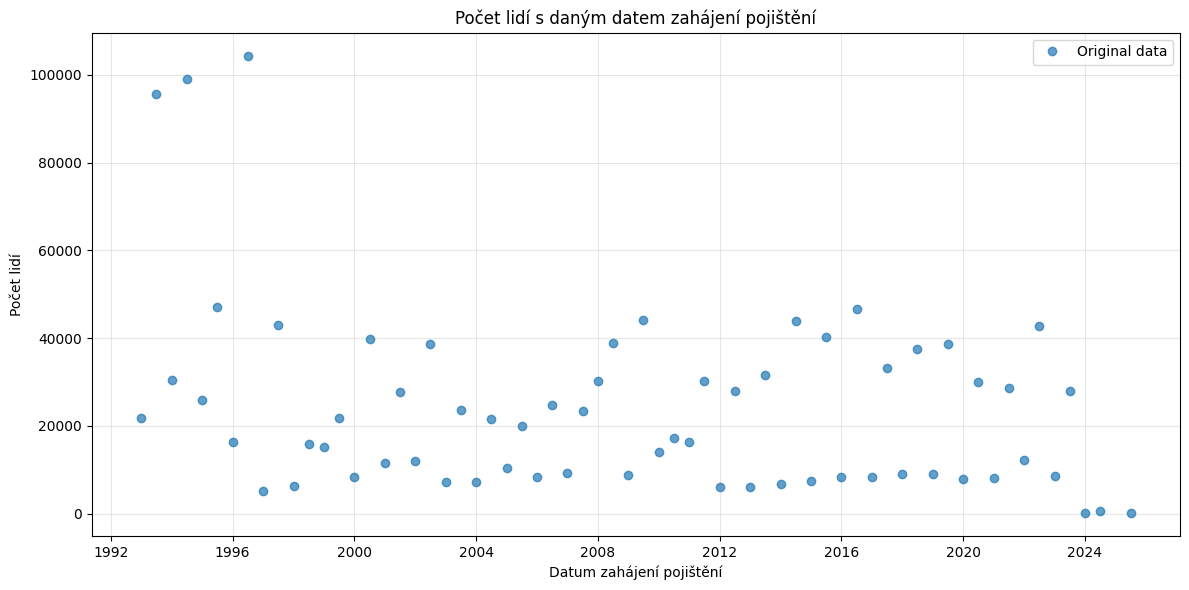

In [3]:
datum_zahajeni_pojisteni_map = {}
for person in persons:
    if person.zahajeni_pojisteni < datetime(1980, 1, 1).date():
        continue
    if person.zahajeni_pojisteni not in datum_zahajeni_pojisteni_map:
        datum_zahajeni_pojisteni_map[person.zahajeni_pojisteni] = 1
    else:
        datum_zahajeni_pojisteni_map[person.zahajeni_pojisteni] += 1

draw_chart(
    mapp=datum_zahajeni_pojisteni_map,
    x_label="Datum zahájení pojištění",
    y_label="Počet lidí",
    title="Počet lidí s daným datem zahájení pojištění",
    average=False,
)

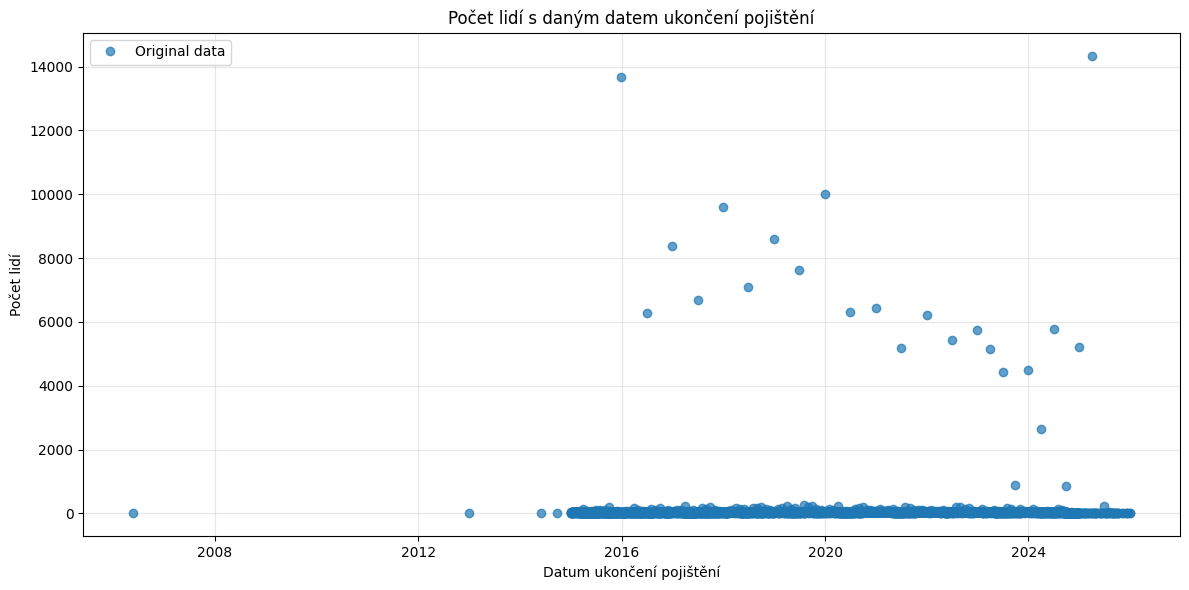

In [4]:
datum_ukonceni_pojisteni_map = {}
for person in persons:
    if not person.ukonceni_pojisteni:
        continue
    if (
        person.ukonceni_pojisteni < datetime(1980, 1, 1).date()
        or person.ukonceni_pojisteni > datetime(2026, 1, 1).date()
    ):
        continue
    if person.ukonceni_pojisteni not in datum_ukonceni_pojisteni_map:
        datum_ukonceni_pojisteni_map[person.ukonceni_pojisteni] = 1
    else:
        datum_ukonceni_pojisteni_map[person.ukonceni_pojisteni] += 1

draw_chart(
    mapp=datum_ukonceni_pojisteni_map,
    x_label="Datum ukončení pojištění",
    y_label="Počet lidí",
    title="Počet lidí s daným datem ukončení pojištění",
    average=False,
)

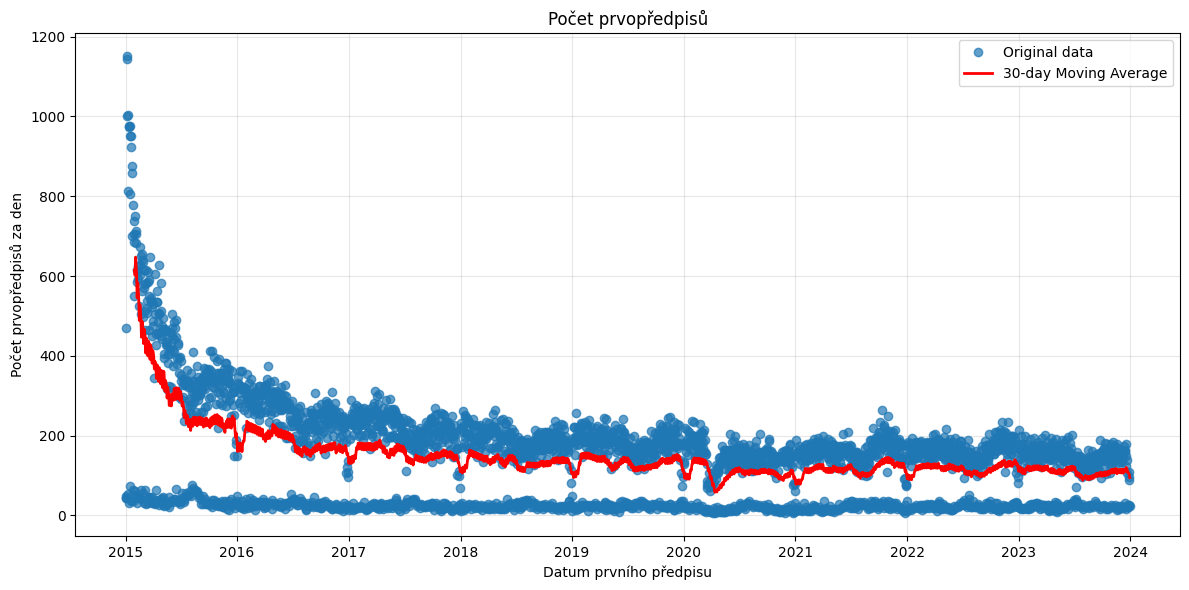

In [5]:
pocet_prvopredpisu_map = defaultdict(int)
for person in persons:
    if person.prescriptions:
        min_prescription = min(person.prescriptions, key=lambda x: x.date)
        pocet_prvopredpisu_map[min_prescription.date] += 1

draw_chart(
    mapp=pocet_prvopredpisu_map,
    x_label="Datum prvního předpisu",
    y_label="Počet prvopředpisů za den",
    title="Počet prvopředpisů",
    average=30,
)

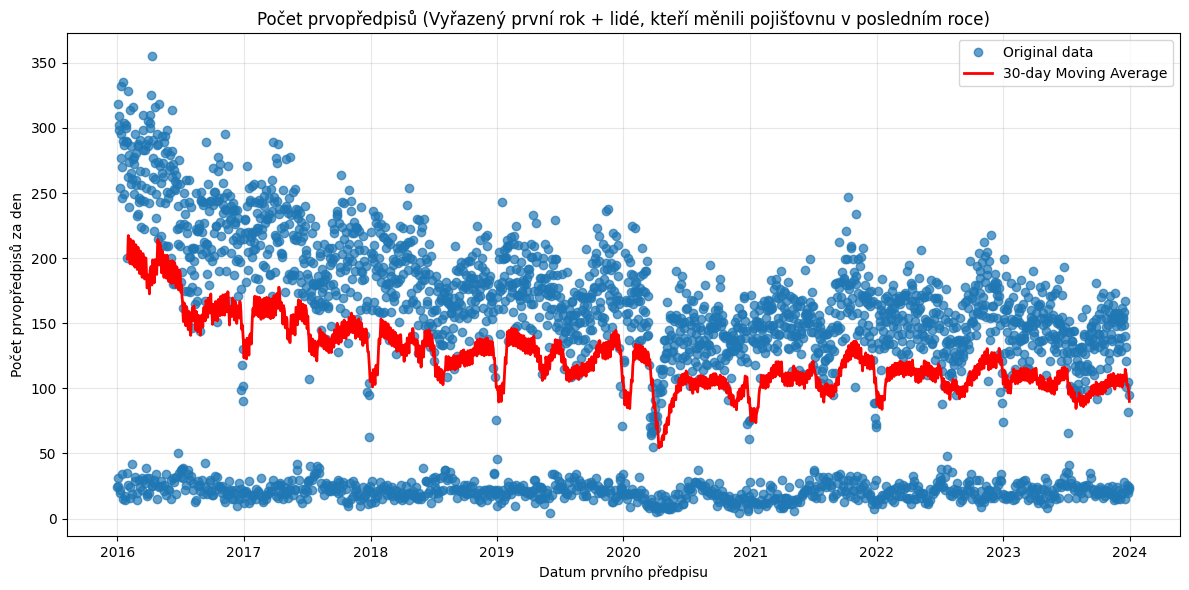

In [6]:
pocet_prvopredpisu_map = defaultdict(int)
for person in persons:
    if person.prescriptions:
        min_prescription = min(person.prescriptions, key=lambda x: x.date)
        if min_prescription.date < datetime(2016, 1, 1).date():
            continue
        if person.zahajeni_pojisteni + timedelta(days=360) < min_prescription.date:
            pocet_prvopredpisu_map[min_prescription.date] += 1

draw_chart(
    mapp=pocet_prvopredpisu_map,
    x_label="Datum prvního předpisu",
    y_label="Počet prvopředpisů za den",
    title="Počet prvopředpisů (Vyřazený první rok + lidé, kteří měnili pojišťovnu v posledním roce)",
    average=30,
)

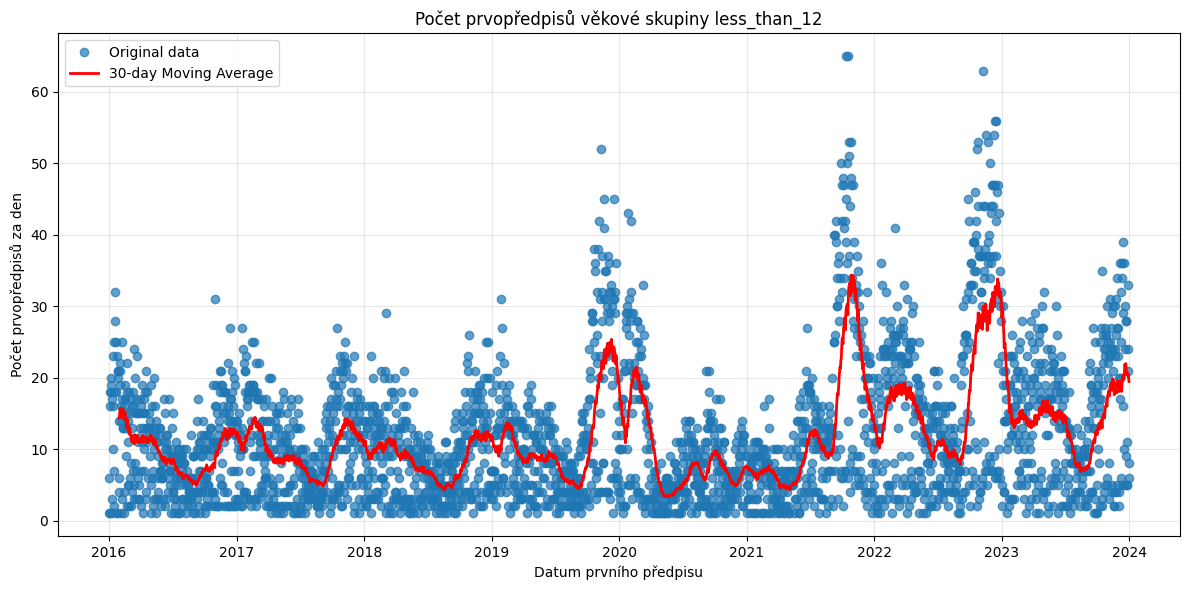

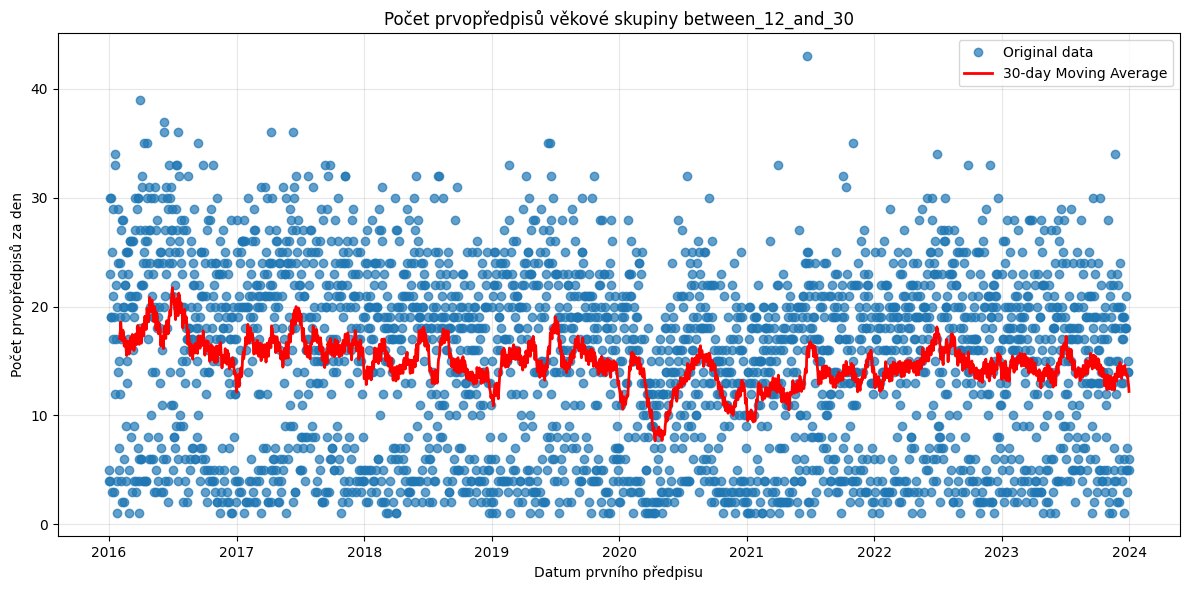

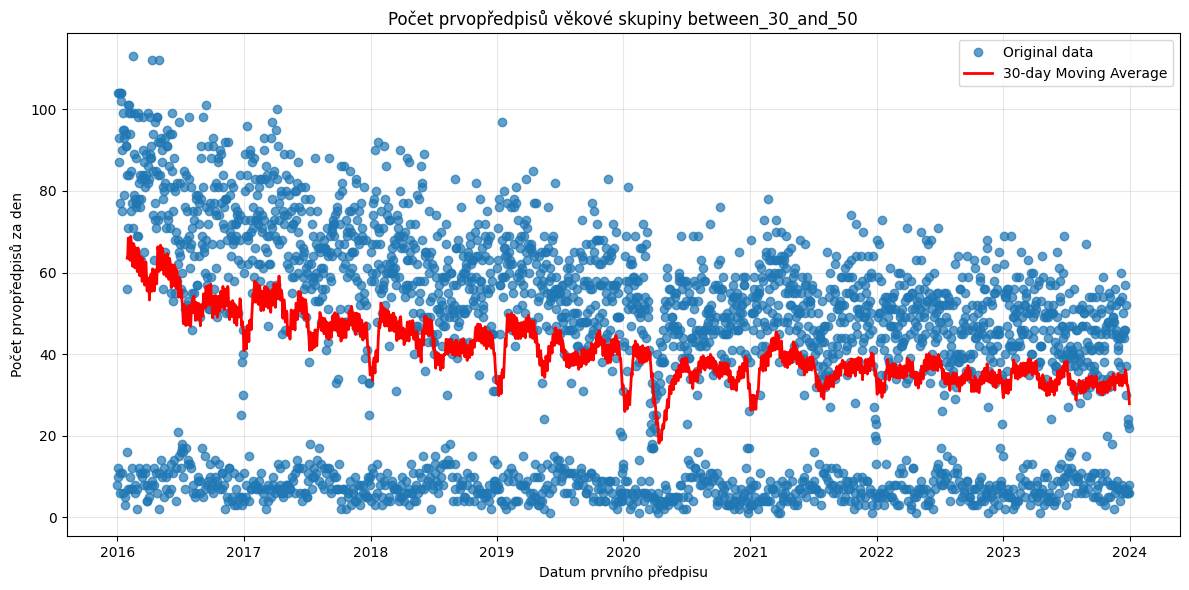

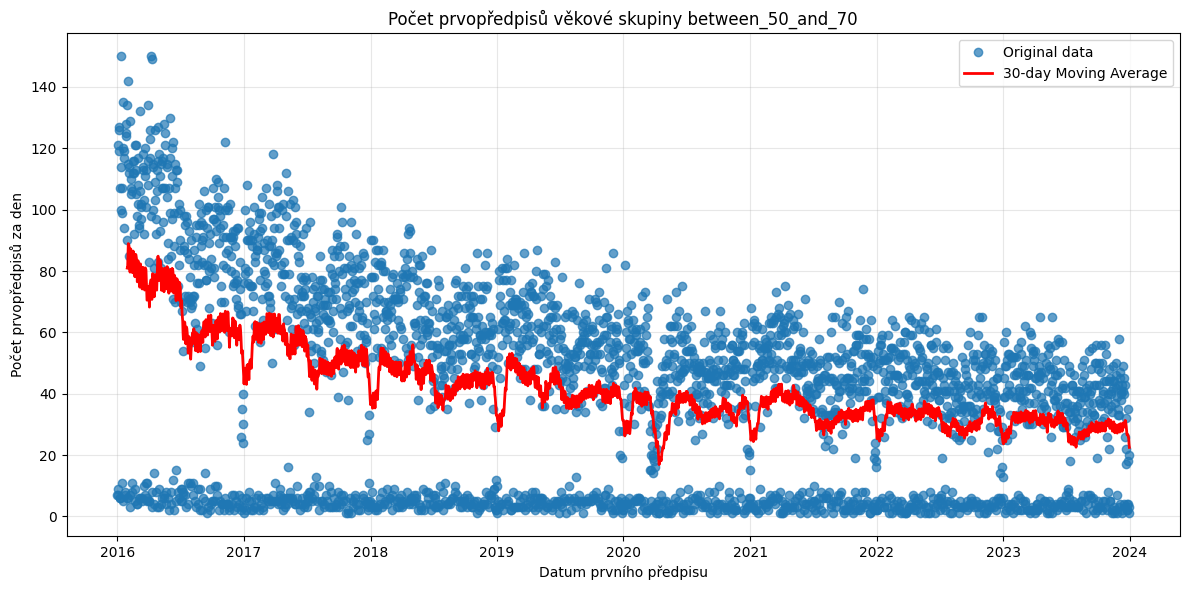

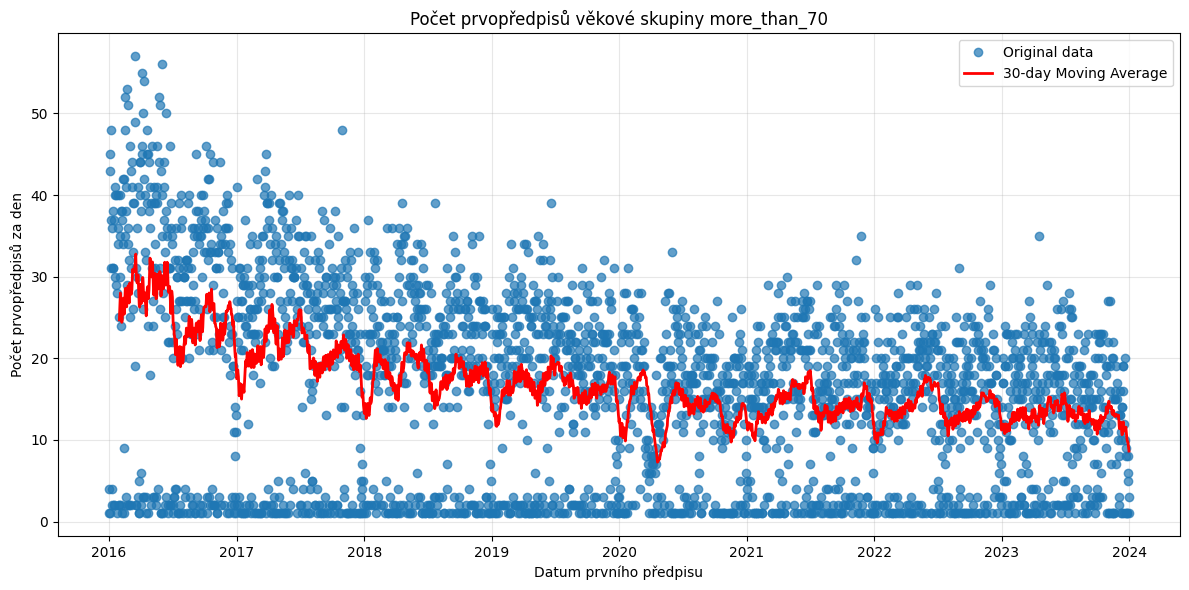

In [7]:
pocet_prvopredpisu_age_cohort_map = defaultdict(lambda: defaultdict(int))

for person in persons:
    if person.prescriptions:
        min_prescription = min(person.prescriptions, key=lambda x: x.date)
        if min_prescription.date < datetime(2016, 1, 1).date():
            continue
        if person.zahajeni_pojisteni + timedelta(days=360) < min_prescription.date:
            pocet_prvopredpisu_age_cohort_map[
                min_prescription.age_cohort_at_prescription
            ][min_prescription.date] += 1


for age_cohort in AgeCohort:
    draw_chart(
        mapp=pocet_prvopredpisu_age_cohort_map[age_cohort],
        x_label="Datum prvního předpisu",
        y_label="Počet prvopředpisů za den",
        title=f"Počet prvopředpisů věkové skupiny {age_cohort}",
        average=30,
    )

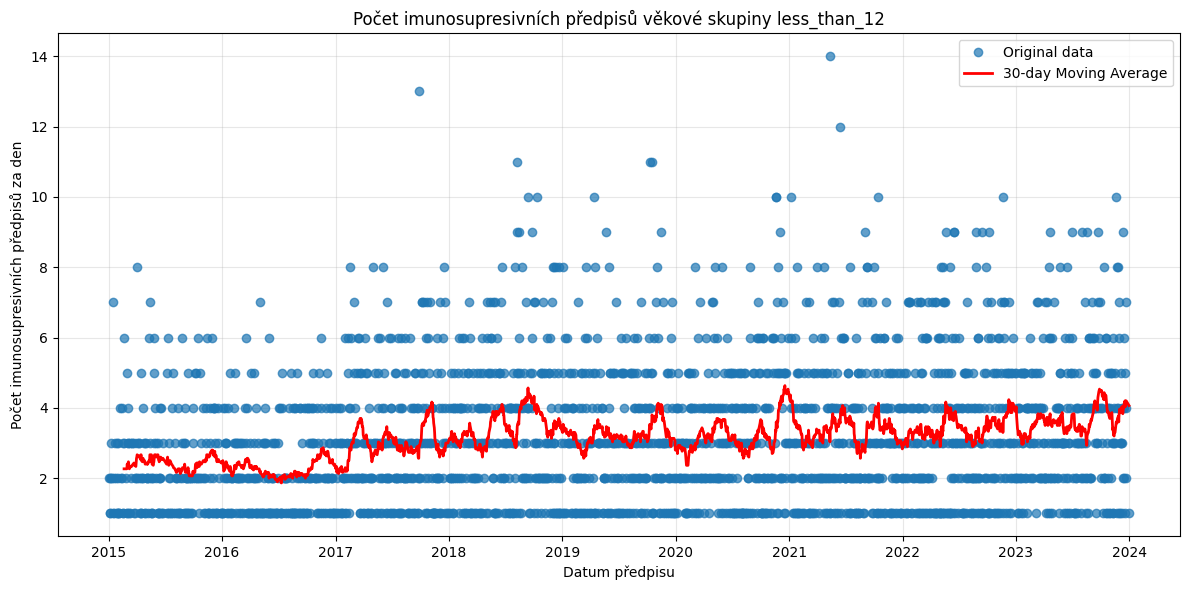

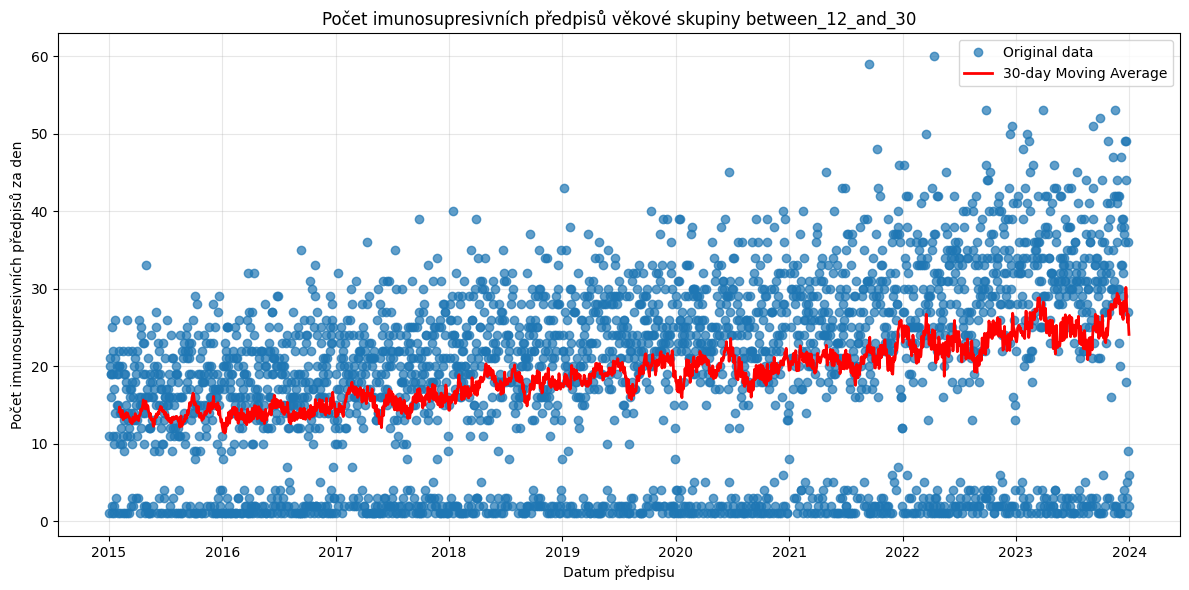

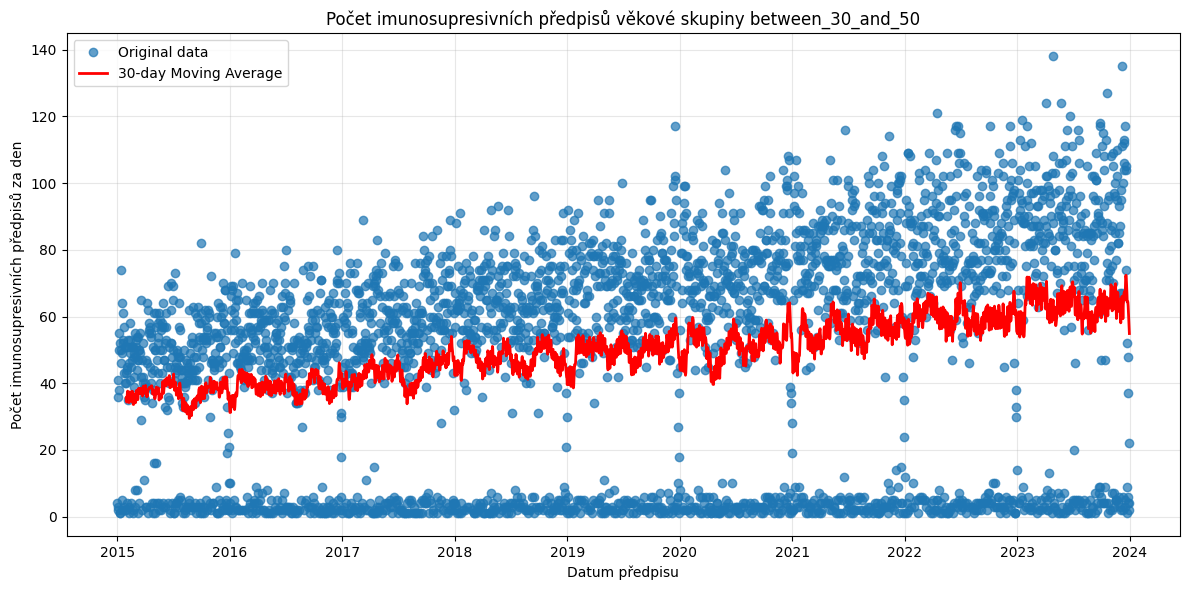

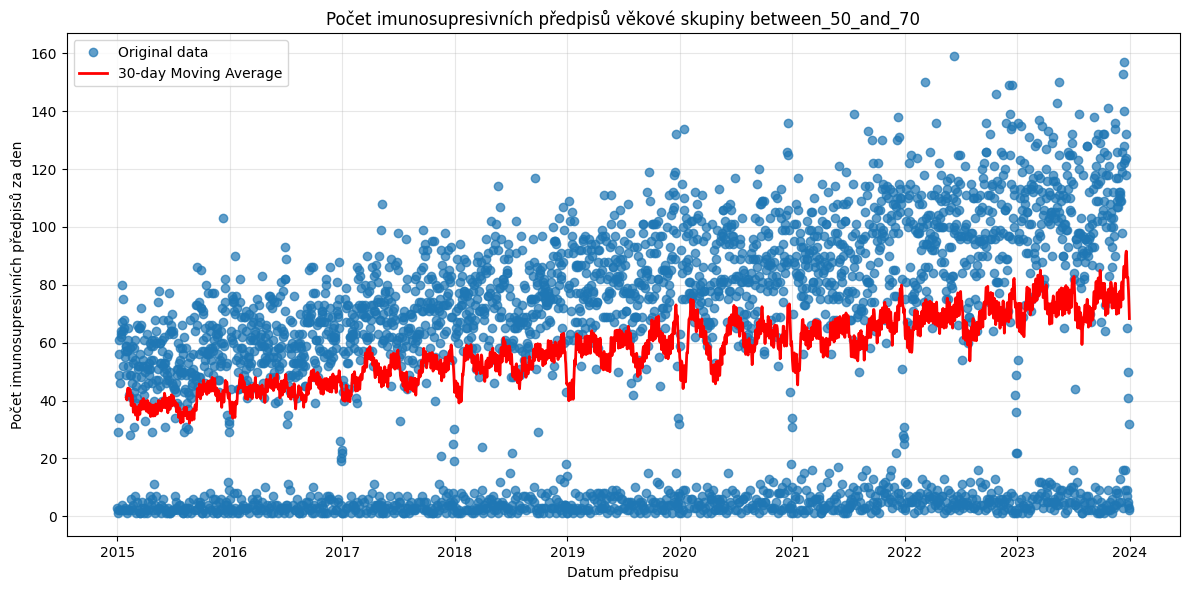

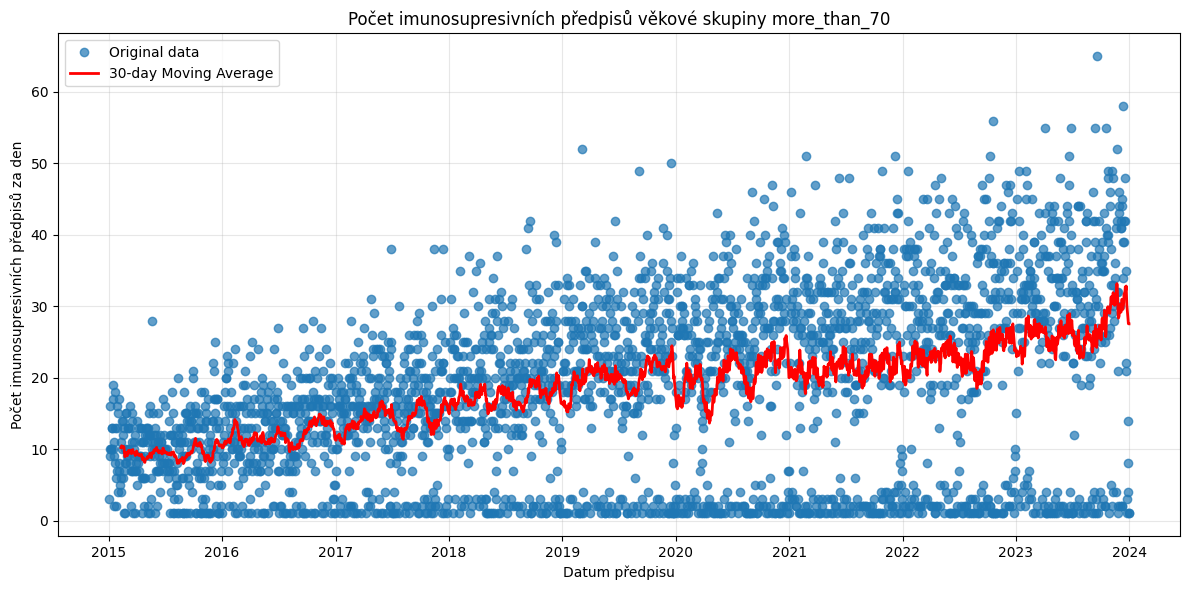

In [8]:
pocet_imunosupresivnich_predpisu_age_cohort_map = defaultdict(lambda: defaultdict(int))

for person in persons:
    for prescription in person.prescriptions:
        if prescription.prescription_type == PrescriptionType.IMUNOSUPRESSIVE:
            pocet_imunosupresivnich_predpisu_age_cohort_map[
                prescription.age_cohort_at_prescription
            ][prescription.date] += 1


for age_cohort in AgeCohort:
    draw_chart(
        mapp=pocet_imunosupresivnich_predpisu_age_cohort_map[age_cohort],
        x_label="Datum předpisu",
        y_label="Počet imunosupresivních předpisů za den",
        title=f"Počet imunosupresivních předpisů věkové skupiny {age_cohort}",
        average=30,
    )

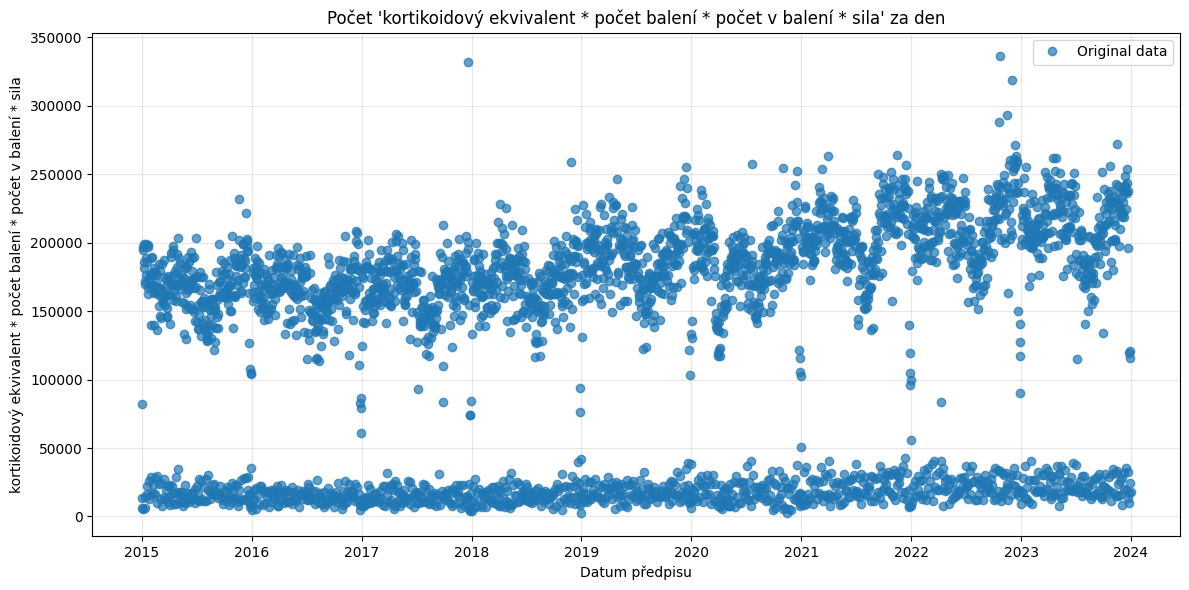

In [11]:
datum_s_kort_ekvivalenty = defaultdict(int)
for person in persons:
    if not person.prescriptions:
        continue
    for prescription in person.prescriptions:
        if prescription.prednison_equiv is None:
            continue
        datum_s_kort_ekvivalenty[prescription.date] += prescription.prednison_equiv

draw_chart(
    mapp=datum_s_kort_ekvivalenty,
    x_label="Datum předpisu",
    y_label="kortikoidový ekvivalent * počet balení * počet v balení * sila",
    title="Počet 'kortikoidový ekvivalent * počet balení * počet v balení * sila' za den",
    average=False,
)

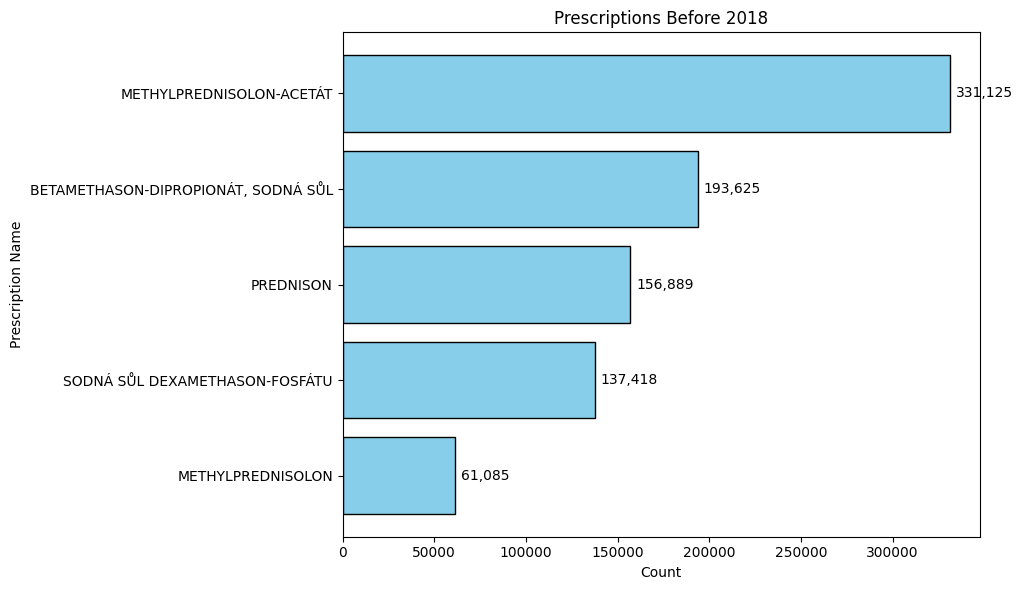

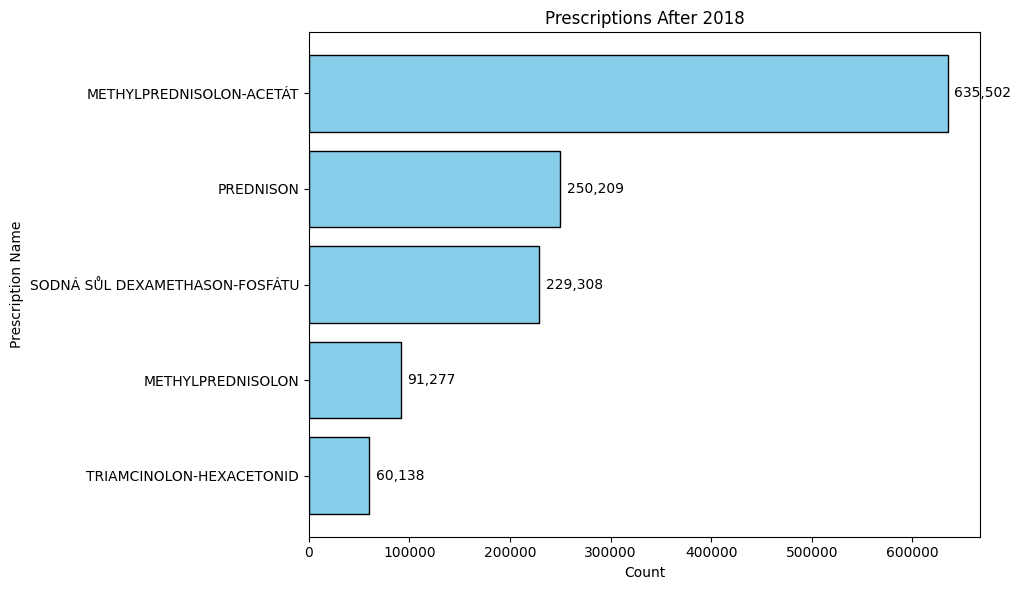

In [12]:
from collections import defaultdict
import matplotlib.pyplot as plt


def draw_top_bar_chart(
    mapp,
    x_label,
    y_label,
    title,
):
    # Sort by value, take top 5, then reverse so biggest is on top
    sorted_items = sorted(mapp.items(), key=lambda item: item[1], reverse=True)[:5]
    sorted_items.reverse()

    y_data = [
        (str(k.value) if hasattr(k, "value") else str(k))[:35] for k, _ in sorted_items
    ]
    x_data = [v for _, v in sorted_items]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(y_data, x_data, color="skyblue", edgecolor="black")

    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.tight_layout()

    # Annotate bars with their values
    for bar, value in zip(bars, x_data):
        plt.text(
            value + max(x_data) * 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{value:,}",
            va="center",
            fontsize=10,
        )

    plt.show()


# --- Data split ---
year_prescription_name_map = defaultdict(lambda: defaultdict(int))

for person in persons:
    for prescription in person.prescriptions:
        year_prescription_name_map[prescription.date.year][prescription.latka] += 1

before_2018 = defaultdict(int)
after_2018 = defaultdict(int)

for year in range(2015, 2019):
    for name, count in year_prescription_name_map[year].items():
        before_2018[name] += count

for year in range(2019, 2026):
    for name, count in year_prescription_name_map[year].items():
        after_2018[name] += count

# --- Charts ---
draw_top_bar_chart(
    before_2018,
    title="Prescriptions Before 2018",
    x_label="Count",
    y_label="Prescription Name",
)

draw_top_bar_chart(
    after_2018,
    title="Prescriptions After 2018",
    x_label="Count",
    y_label="Prescription Name",
)

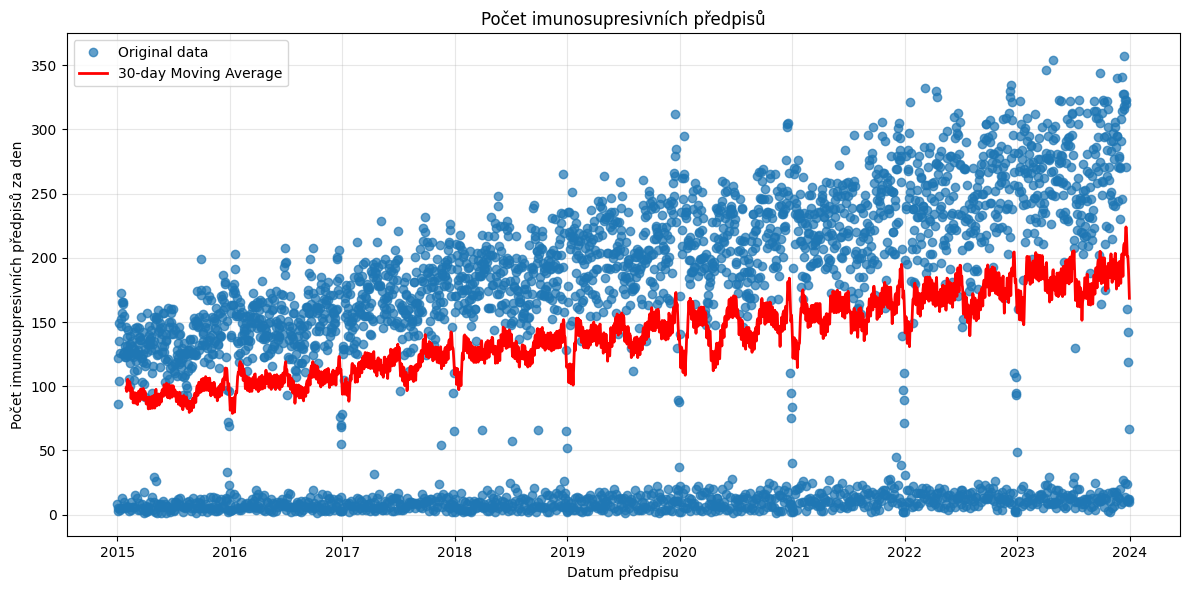

In [13]:
datum_s_imunosupresivy = {}
for person in persons:
    if not person.prescriptions:
        continue
    for prescription in person.prescriptions:
        if prescription.prescription_type != PrescriptionType.IMUNOSUPRESSIVE:
            continue
        if prescription.date not in datum_s_imunosupresivy:
            datum_s_imunosupresivy[prescription.date] = 1
        else:
            datum_s_imunosupresivy[prescription.date] += 1

draw_chart(
    mapp=datum_s_imunosupresivy,
    x_label="Datum předpisu",
    y_label="Počet imunosupresivních předpisů za den",
    title="Počet imunosupresivních předpisů",
    average=30,
)

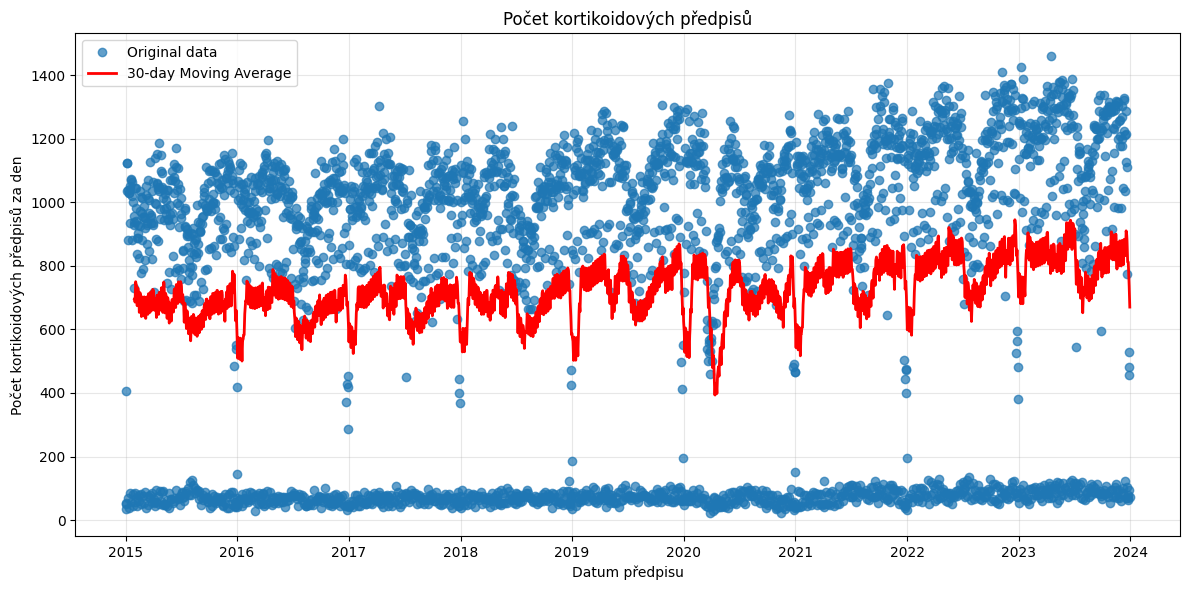

In [14]:
datum_s_kortikoidy = {}
for person in persons:
    if not person.prescriptions:
        continue
    for prescription in person.prescriptions:
        if (
            prescription.prescription_type != PrescriptionType.KORTIKOID
            or not prescription.prednison_equiv
        ):
            continue
        if prescription.date not in datum_s_kortikoidy:
            datum_s_kortikoidy[prescription.date] = 1
        else:
            datum_s_kortikoidy[prescription.date] += 1

draw_chart(
    mapp=datum_s_kortikoidy,
    x_label="Datum předpisu",
    y_label="Počet kortikoidových předpisů za den",
    title="Počet kortikoidových předpisů",
    average=30,
)

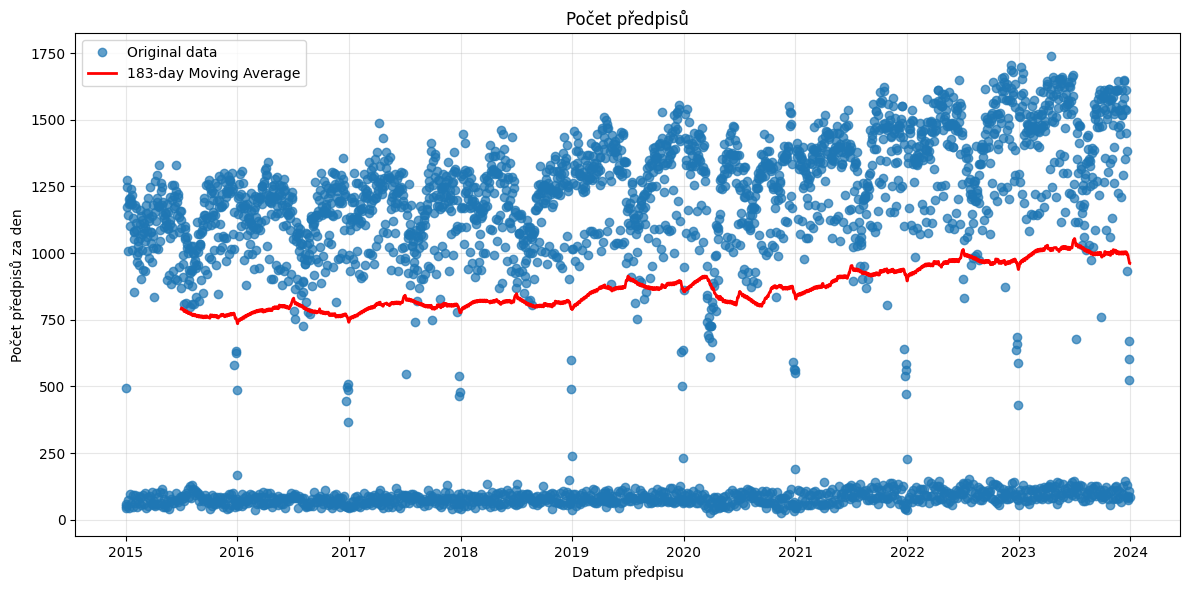

In [15]:
datum_predpisu = {}
for person in persons:
    if not person.prescriptions:
        continue
    for prescription in person.prescriptions:
        if prescription.date not in datum_predpisu:
            datum_predpisu[prescription.date] = 1
        else:
            datum_predpisu[prescription.date] += 1

draw_chart(
    mapp=datum_predpisu,
    x_label="Datum předpisu",
    y_label="Počet předpisů za den",
    title="Počet předpisů",
    average=183,
)

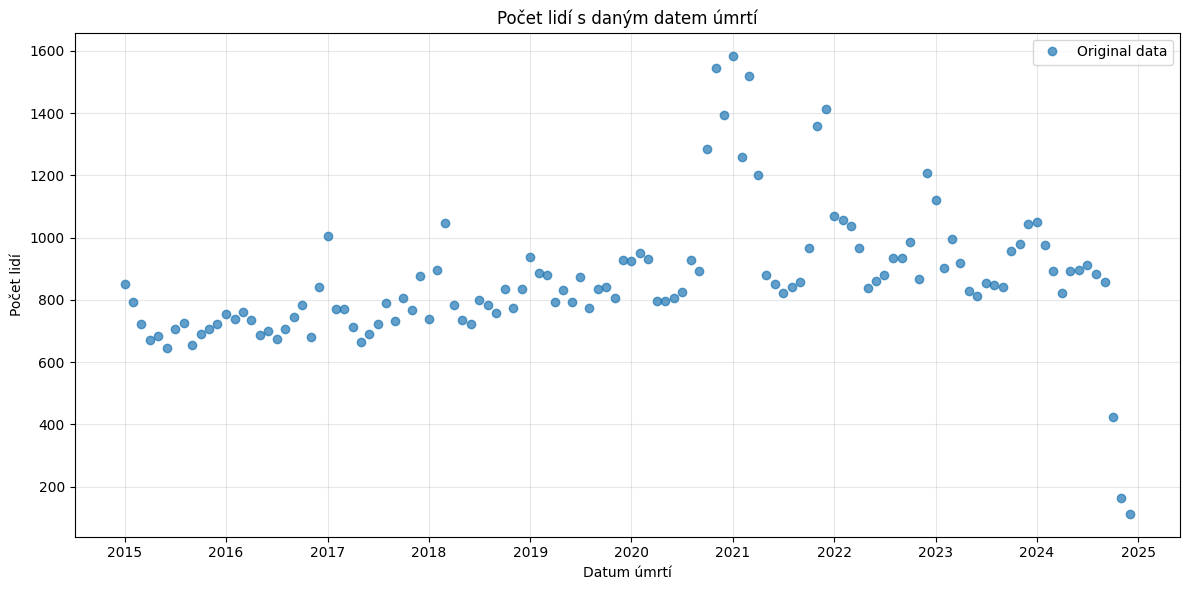

In [16]:
datum_umrti = {}
for person in persons:
    if not person.died_at:
        continue
    if person.died_at not in datum_umrti:
        datum_umrti[person.died_at] = 1
    else:
        datum_umrti[person.died_at] += 1

draw_chart(
    mapp=datum_umrti,
    x_label="Datum úmrtí",
    y_label="Počet lidí",
    title="Počet lidí s daným datem úmrtí",
    average=None,
)

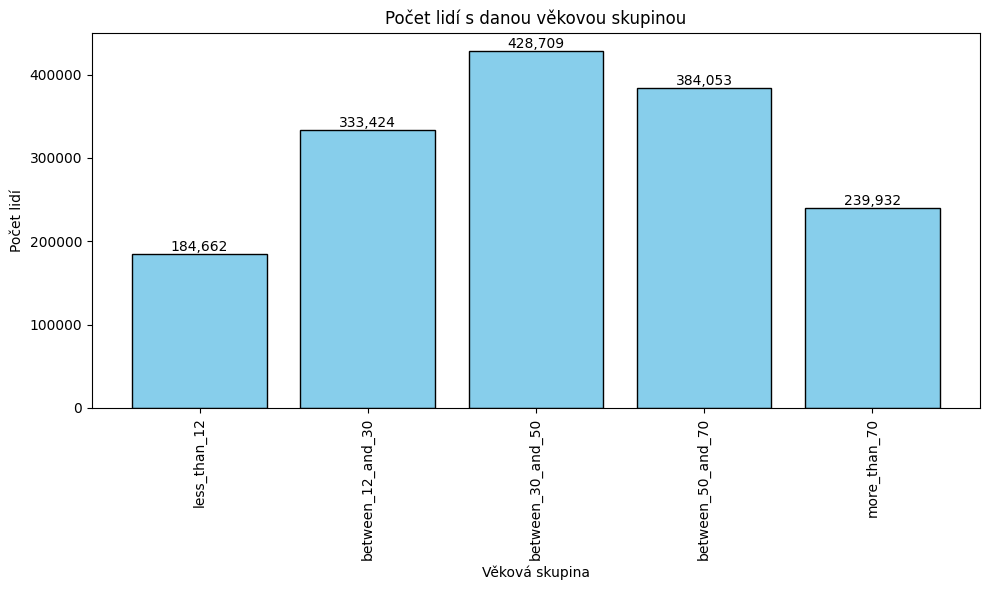

In [17]:
age_cohort_map = {
    AgeCohort.LESS_THAN_12: 0,
    AgeCohort.BETWEEN_12_AND_30: 0,
    AgeCohort.BETWEEN_30_AND_50: 0,
    AgeCohort.BETWEEN_50_AND_70: 0,
    AgeCohort.MORE_THAN_70: 0,
}
for person in persons:
    age_cohort_map[person.age_cohort] += 1

draw_bar_chart(
    mapp=age_cohort_map,
    x_label="Věková skupina",
    y_label="Počet lidí",
    title="Počet lidí s danou věkovou skupinou",
)

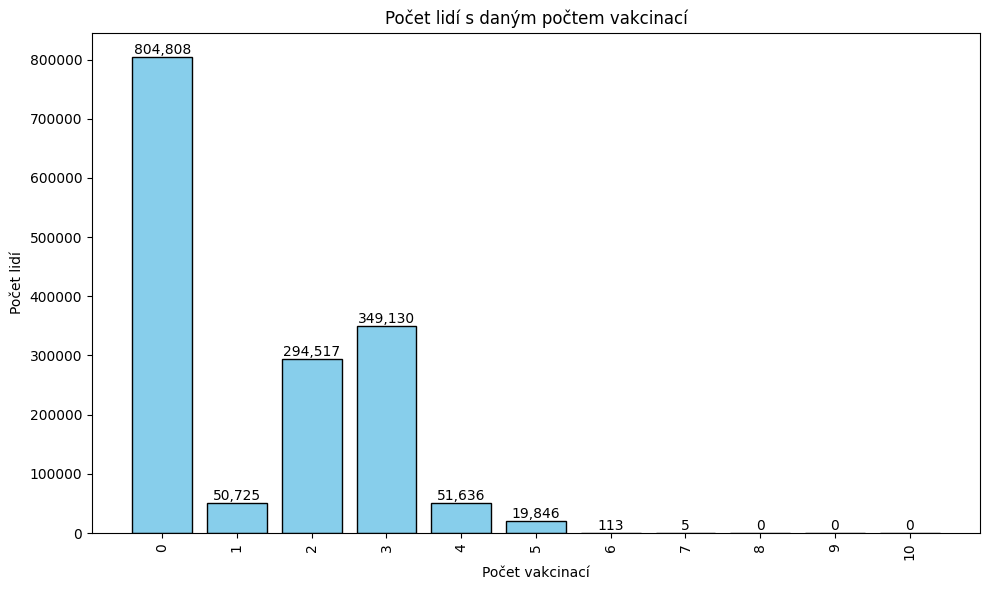

In [18]:
pocet_vakcin_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0,
    8: 0,
    9: 0,
    10: 0,
}
for person in persons:
    pocet_vakcin_map[len(person.vaccines)] += 1

draw_bar_chart(
    mapp=pocet_vakcin_map,
    x_label="Počet vakcinací",
    y_label="Počet lidí",
    title="Počet lidí s daným počtem vakcinací",
)

In [19]:
vax_persons = [p for p in persons if p.vaccines]
novax_persons = [p for p in persons if not p.vaccines]

print(f"Počet osob s vakcínami: {len(vax_persons)}")
print(f"Počet osob bez vakcín: {len(novax_persons)}")
print(f"Procento proočkování: {len(vax_persons) / len(persons) * 100:.2f}%")

Počet osob s vakcínami: 765972
Počet osob bez vakcín: 804808
Procento proočkování: 48.76%


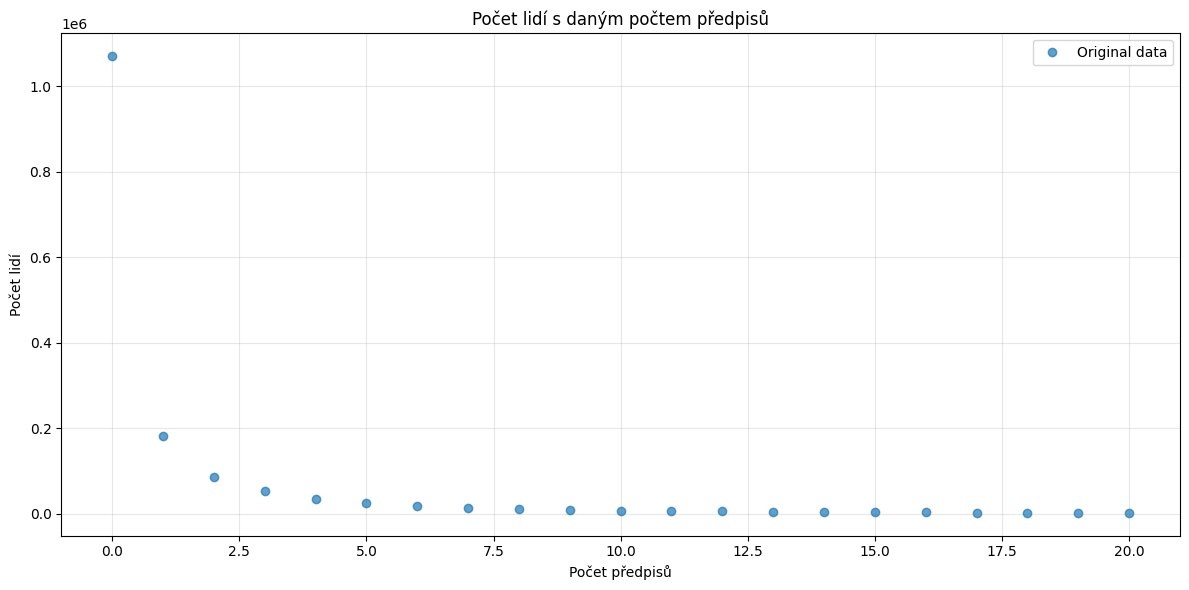

In [20]:
pocet_predpisu_map = defaultdict(int)
for person in persons:
    if len(person.prescriptions) > 800:
        print(person)
    if len(person.prescriptions) > 20:
        continue
    pocet_predpisu_map[len(person.prescriptions)] += 1

draw_chart(
    mapp=pocet_predpisu_map,
    x_label="Počet předpisů",
    y_label="Počet lidí",
    title="Počet lidí s daným počtem předpisů",
)

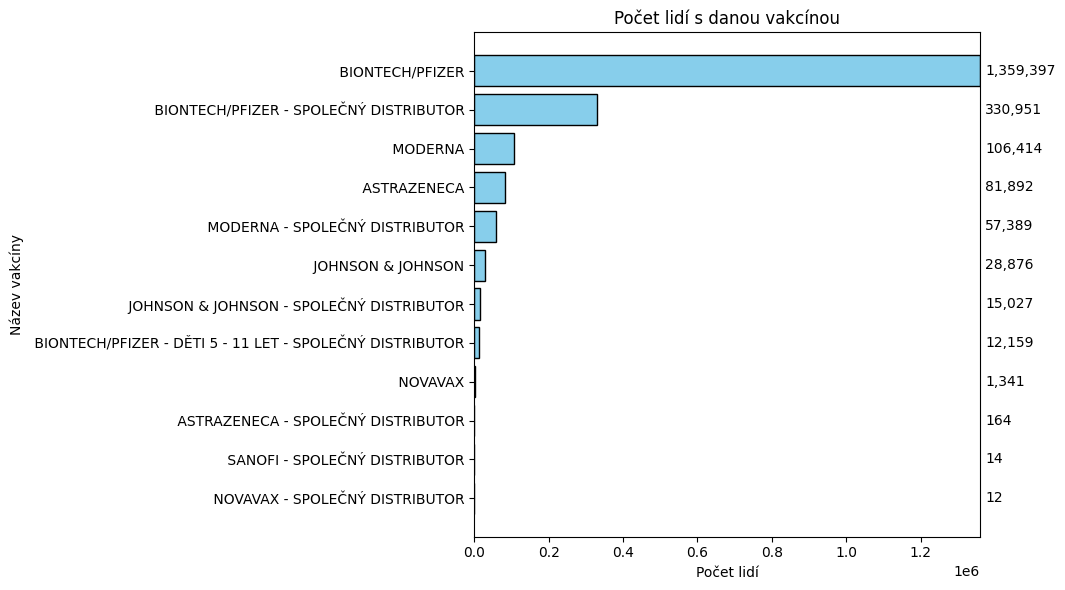

In [21]:
from collections import defaultdict
import matplotlib.pyplot as plt

nazvy = defaultdict(int)

for person in persons:
    for vaccine in person.vaccines:
        nazvy[vaccine.nazev] += 1

x_data = [str(k).replace("COVID-19 - OČKOVÁNÍ -", "") for k in nazvy.keys()]
y_data = list(nazvy.values())

# Sort by count descending
x_data, y_data = zip(*sorted(zip(x_data, y_data), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 6))
bars = plt.barh(x_data, y_data, color="skyblue", edgecolor="black")

plt.ylabel("Název vakcíny")
plt.xlabel("Počet lidí")
plt.title("Počet lidí s danou vakcínou")
plt.gca().invert_yaxis()  # biggest bar at the top
plt.tight_layout()

# Set a little padding on the right for labels
max_val = max(y_data)
plt.xlim(0, max_val)

# Place labels at the far right edge
for bar, value in zip(bars, y_data):
    plt.text(
        max_val * 1.01,  # near right edge
        bar.get_y() + bar.get_height() / 2,
        f"{value:,}",
        ha="left",
        va="center",
        fontsize=10,
    )

plt.show()

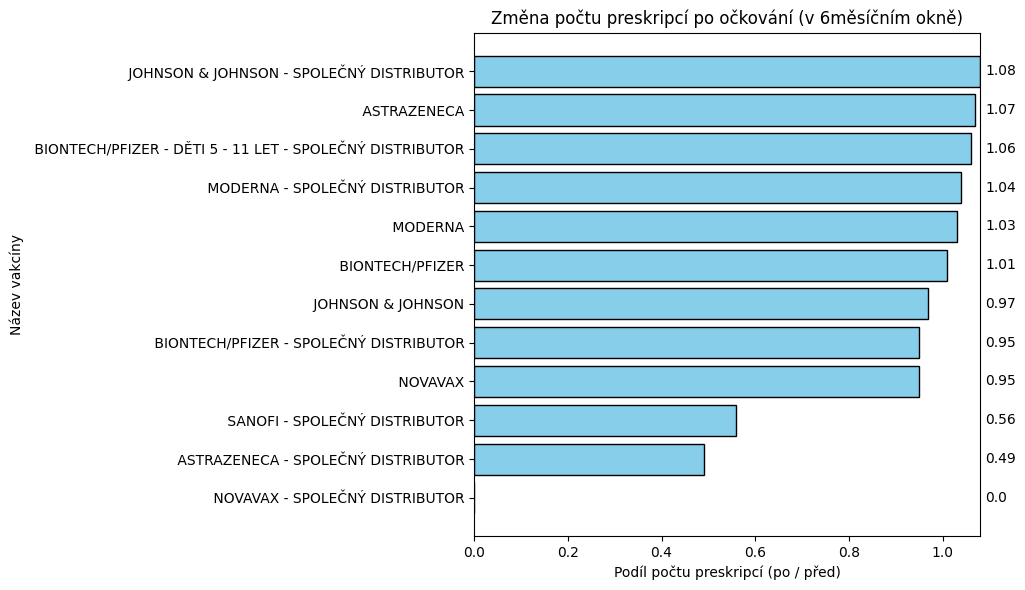

In [22]:
from collections import defaultdict
from datetime import timedelta

# Parametry analýzy
window = timedelta(days=180)

# Uložíme: nazev vakcíny -> [počty před], [počty po]
prescription_counts_by_vaccine: dict[str, tuple[list[int], list[int]]] = defaultdict(
    lambda: ([], [])
)

for person in persons:
    for vaccine in person.vaccines:
        if not vaccine.nazev:
            continue

        before_count = sum(
            1
            for p in person.prescriptions
            if vaccine.date - window <= p.date < vaccine.date
        )
        after_count = sum(
            1
            for p in person.prescriptions
            if vaccine.date < p.date <= vaccine.date + window
        )

        before_list, after_list = prescription_counts_by_vaccine[
            vaccine.nazev.replace("COVID-19 - OČKOVÁNÍ -", "")
        ]
        before_list.append(before_count)
        after_list.append(after_count)

# Vypočítáme průměry
tot_prescriptions_by_vaccine = {
    nazev: {"before": round(sum(before), 2), "after": round(sum(after), 2)}
    for nazev, (before, after) in prescription_counts_by_vaccine.items()
}

# Volitelně spočítáme rozdíl (after - before) – pro vizualizaci
difference_by_vaccine = {
    nazev: round(data["after"] / data["before"], 2)
    for nazev, data in tot_prescriptions_by_vaccine.items()
}

x_data = [
    str(k).replace("COVID-19 - OČKOVÁNÍ -", "") for k in difference_by_vaccine.keys()
]
y_data = list(difference_by_vaccine.values())

# Sort by count descending
x_data, y_data = zip(*sorted(zip(x_data, y_data), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 6))
bars = plt.barh(x_data, y_data, color="skyblue", edgecolor="black")

plt.ylabel("Název vakcíny")
plt.xlabel("Podíl počtu preskripcí (po / před)")
plt.title(f"Změna počtu preskripcí po očkování (v {window.days // 30}měsíčním okně)")
plt.gca().invert_yaxis()  # biggest bar at the top
plt.tight_layout()

# Set a little padding on the right for labels
max_val = max(y_data)
plt.xlim(0, max_val)

# Place labels at the far right edge
for bar, value in zip(bars, y_data):
    plt.text(
        max_val * 1.01,  # near right edge
        bar.get_y() + bar.get_height() / 2,
        f"{value:,}",
        ha="left",
        va="center",
        fontsize=10,
    )

plt.show()

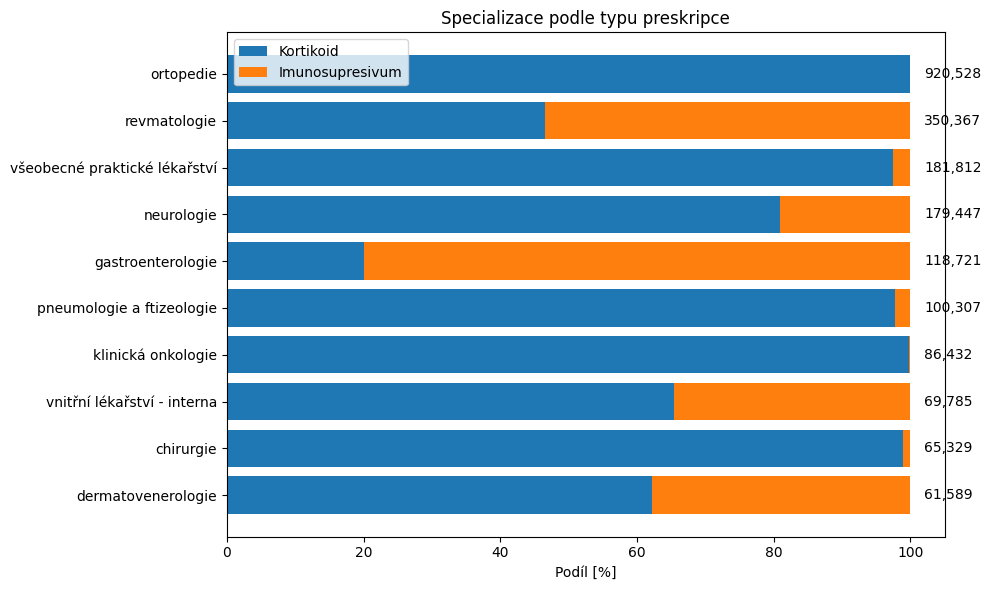

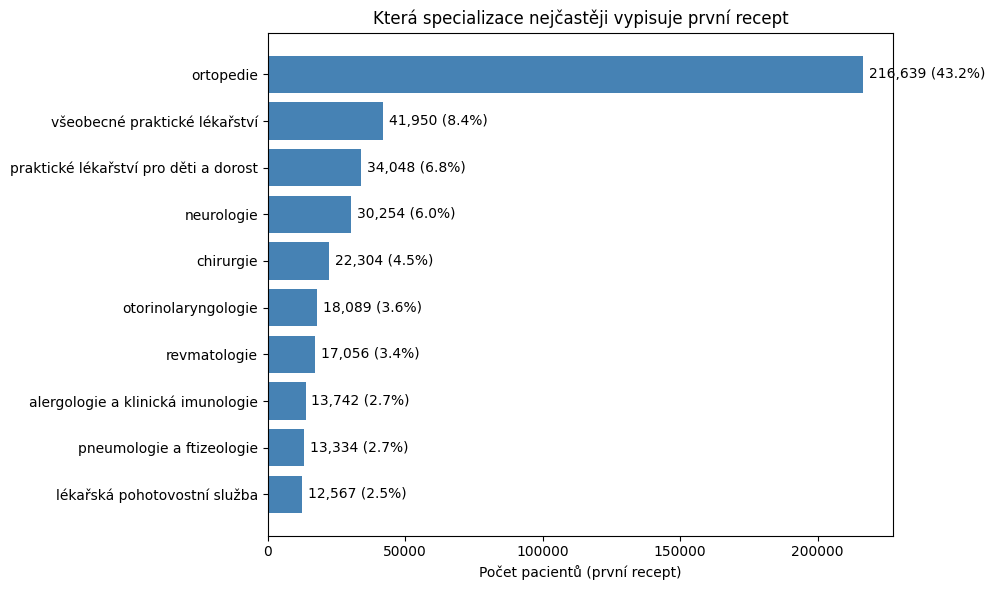

In [23]:
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# Initialize the data dictionary
data = defaultdict(lambda: {"kortikoid": 0, "imunosupressive": 0})

# Process prescriptions for each person
for person in persons:
    last_prescription_date = datetime.min.date()
    for presc in person.prescriptions:
        if presc.specializace_lekare is None:
            continue
        if presc.lekova_forma in ["Injekční suspenze", "Injekční/infuzní roztok"]:
            if abs((last_prescription_date - presc.date).days) < 14:
                continue
        last_prescription_date = presc.date
        data[presc.specializace_lekare][presc.prescription_type.value] += 1

# Process for total counts and percentages
specializations = []
kortikoid_pct = []
imunosupressive_pct = []
total_counts = []

for spec, counts in data.items():
    total = counts["kortikoid"] + counts["imunosupressive"]
    specializations.append(spec)
    kortikoid_pct.append(counts["kortikoid"] / total * 100)
    imunosupressive_pct.append(counts["imunosupressive"] / total * 100)
    total_counts.append(total)

# Sort by total counts in descending order and limit to top 10
sorted_data = sorted(
    zip(specializations, kortikoid_pct, imunosupressive_pct, total_counts),
    key=lambda x: x[3],
    reverse=True,
)[:10]

specializations, kortikoid_pct, imunosupressive_pct, total_counts = zip(*sorted_data)

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
y = np.arange(len(specializations))
ax.barh(y, kortikoid_pct, label="Kortikoid")
ax.barh(y, imunosupressive_pct, left=kortikoid_pct, label="Imunosupresivum")

for i, total in enumerate(total_counts):
    ax.text(102, i, f"{total:,}", va="center")

ax.set_yticks(y)
ax.invert_yaxis()  # Reverse order for the largest on top
ax.set_yticklabels(specializations)
ax.set_xlabel("Podíl [%]")
ax.set_title("Specializace podle typu preskripce")
ax.legend()
plt.tight_layout()
plt.show()

# Collect first prescriptions
rows = []
for person in persons:
    for presc in person.prescriptions:
        rows.append(
            {
                "person_id": person.id,
                "date": presc.date,
                "specializace_lekare": presc.specializace_lekare,
            }
        )

# Group by person and find the first prescription
first_prescriptions = defaultdict(list)
for row in rows:
    first_prescriptions[row["person_id"]].append(row)

first_prescriptions = {
    person_id: sorted(prescs, key=lambda x: x["date"])[0]
    for person_id, prescs in first_prescriptions.items()
}

# Group by specialization and count first prescriptions
specialization_counts = defaultdict(int)
for presc in first_prescriptions.values():
    specialization_counts[presc["specializace_lekare"]] += 1

# Calculate percentages
total_first_recepts = sum(specialization_counts.values())
specialization_stats = [
    {
        "specializace_lekare": spec,
        "first_recept_count": count,
        "pct": (count / total_first_recepts) * 100,
    }
    for spec, count in specialization_counts.items()
]

# Sort by first prescription count and limit to top 10
specialization_stats.sort(key=lambda x: x["first_recept_count"], reverse=True)
df_plot = specialization_stats[:10]

specializations = [entry["specializace_lekare"] for entry in df_plot]
counts = [entry["first_recept_count"] for entry in df_plot]
pct = [entry["pct"] for entry in df_plot]

# Plot first prescription counts
fig, ax = plt.subplots(figsize=(10, 6))
y = np.arange(len(specializations))
ax.barh(y, counts, color="steelblue")

for i, (val, p) in enumerate(zip(counts, pct)):
    ax.text(val + max(counts) * 0.01, i, f"{val:,} ({p:.1f}%)", va="center")

ax.set_yticks(y)
ax.set_yticklabels(specializations)
ax.invert_yaxis()  # Reverse order for the largest on top
ax.set_xlabel("Počet pacientů (první recept)")
ax.set_title("Která specializace nejčastěji vypisuje první recept")

plt.tight_layout()
plt.show()